In [1]:
# Import cubeit functions

import pytest
import numpy as np
import signal
import cubeit.DMs as dms
from cubeit.gates_DMs import(
    x, y, z, had, s, t, cnot, cnot_10, phase, rotation_x, rotation_y, rotation_z, swap, cz, cphase
)
from cubeit.visualisation import plot_bloch_sphere, plot_circuit, simulate_measurements
import os
import threading
import time

#Import plotting and visualisation libraries

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, Text, SelectMultiple, Layout, VBox, HBox, Button, Dropdown, Output, Label, HTML, GridBox, FloatSlider, get_ipython
from IPython.display import display
import datetime

In [4]:
def get_gates_targets(string):
    """
    Parses user input string to extract quantum gates and their targets.
    
    Args:
        string (str): Input string containing Gate(target) commands separated by semicolons. For rotations, the format is Gate(arg)(target).

    Returns:
        tuple: A tuple containing two lists - one for gates (with arguments if applicable) and another for targets.
    """
    gates = []
    targets = []
    commands = string.split(';')        #Iterate over each command separated by semicolon
    for cmd in commands:
        if len(cmd)>1:      
            cmd = cmd.strip()
            if not cmd or "(" not in cmd or not cmd.endswith(")"):
                print("Invalid command:", cmd)
                continue
            if ")(" in cmd:         #Check for rotation gates with arguments
                cmd = cmd.split('(')
                gate = cmd[0]
                arg = cmd[1][:-1]
                target = cmd[2][:-1]
                if ',' in target:
                    target = (int(target[0], int(target[2])))
                else:
                    target = int(target)
                gates.append((gate,arg))
                targets.append(target)
            else:                   #Standard gates without arguments
                cmd = cmd.split('(')
                gate = cmd[0]
                target = cmd[1][:-1]
                if ',' in target:
                    target = (int(target[0], int(target[2])))
                else:
                    target = int(target)
                gates.append(gate)
                targets.append(target)
    return gates, targets

def gates_lookup(gates):
    """
    Maps gate names to their corresponding gate functions.

    Args:
        gates (list): List of gate names (str) or tuples for rotation gates with arguments.

    Returns:
        list: List of gate functions corresponding to the input gate names.
    """
    gate_functions = []
    for gate in gates:
        if isinstance(gate, tuple):
            gate_name, arg = gate   #Rotation gates with arguments
            if gate_name == 'Rotation_x':
                gate_functions.append(rotation_x(float(arg)))
            elif gate_name == 'Rotation_y':
                gate_functions.append(rotation_y(float(arg)))
            elif gate_name == 'Rotation_z':
                gate_functions.append(rotation_z(float(arg)))
            elif gate_name == 'Phase':
                gate_functions.append(phase(float(arg)))
            elif gate_name == 'Cphase':
                gate_functions.append(cphase(float(arg)))
            else:
                print(f"Unknown gate with argument: {gate_name}")
        else:               #Standard gates without arguments
            if gate == 'X':
                gate_functions.append(x())
            elif gate == 'Y':
                gate_functions.append(y())
            elif gate == 'Z':
                gate_functions.append(z())
            elif gate == 'Had':
                gate_functions.append(had())
            elif gate == 'S':
                gate_functions.append(s())
            elif gate == 'T':
                gate_functions.append(t())
            elif gate == 'CNOT':
                gate_functions.append(cnot())
            elif gate == 'CNOT':
                gate_functions.append(cnot_10())
            elif gate == 'SWAP':
                gate_functions.append(swap())
            elif gate == 'CZ':
                gate_functions.append(cz())
            else:
                print(f"Unknown gate: {gate}")
    return gate_functions

def plot_measure(state, shots=1000):
    fig, ax = plt.subplots(figsize=(3, 5))
    basis_states = {'|00>': 0, '|01>': 0, '|10>': 0, '|11>': 0}
    meast = simulate_measurements(state, num_samples=int(shots))
    for k in basis_states:
        k_ = k.replace('|', '').replace('>', '')
        if k_ in meast:
            basis_states[k] = float(meast[k_])/float(shots)
    ax.bar(list(basis_states.keys()), list(basis_states.values()), 0.25)
    ax.set_title(f'Measurement over {shots} shots')
    ax.set_ylabel('Probability')
    plt.show()
    return fig


GridBox(children=(HTML(value="<h2 style='color:blue;'>Cub<i>e</i><sup>it</sup> Quantum Circuit Simulator</h2>"…

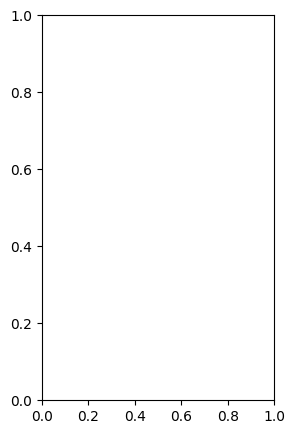

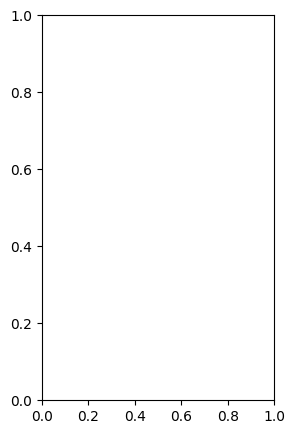

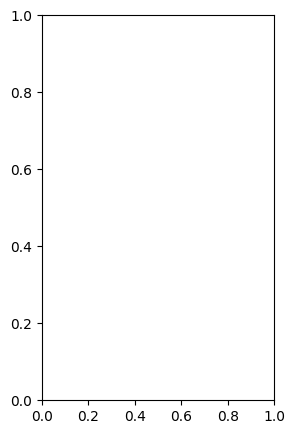

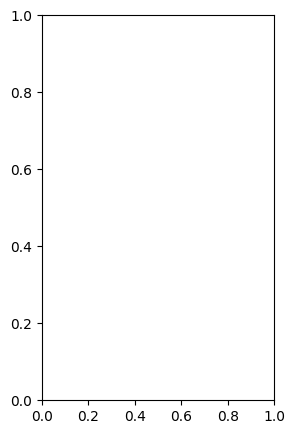

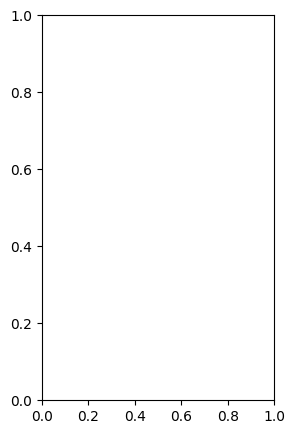

In [6]:
state = None
last_bloch_fig = None
last_circuit_fig = None
last_measurement_fig = None

# Widgets
title = HTML("<h2 style='color:blue;'>Cub<i>e</i><sup>it</sup> Quantum Circuit Simulator</h2>")
init_label = HTML("<b>&larr;Initialise 2-qubit system in |00>, or enter [a,b,c,d] for [a|00>+b|01>+c|10>+d|11>].</b>")
reinit_btn = Button(description="Initialise")
gate_label = HTML("<b>&larr; Enter gates and target qubits, e.g. Had(0);CNOT(0,1)Rotation_x(pi)(0)</b>")
text_in = Text(description="Gates:")
state_in = Text(description="State:")
send_btn = Button(description="Apply gates")
noise_dropdown = Dropdown(options=["None", "Depolarizing", "Dephasing", "Amplitude Damping"], description="Noise:")
noise_slider = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description="Level:")
apply_noise_btn = Button(description="Apply noise")
out = Output()
out1 = Output()
out2 = Output()
save_label = HTML("<b>&larr; Enter filename prefix to save all figures</b>")
filename_box = Text(description="Filename:")
save_button = Button(description="Save Figures")
exit_btn = Button(description="Exit", button_style='danger')


# Handlers
def on_initialise(_):
    out.clear_output()
    out1.clear_output()
    out2.clear_output()
    with out:
        global rho
        if state_in:
            state_in_ = state_in.value
        else:
            state_in_ = ""
        if len(state_in_.strip()) <1:
            init_state = [1.0,0.,0.,0.]
        else:
            init_state = [complex(x) for x in state_in_.strip().split(',')]
            if not len(init_state) ==4:
                print("Invalid initial state, must be 4 complex numbers separated by commas.")
                init_state = [1.0,0.,0.,0.]

        state = np.array(init_state, dtype=complex)
        rho_ = np.outer(state, state)
        rho = dms.DensityMatrix2Qubit(rho_)
        global last_bloch_fig
        last_bloch_fig = plot_bloch_sphere(rho)
    with out2:
        global last_measurement_fig
        last_measurement_fig = plot_measure(rho, shots=1000)

def on_send(_):
    out.clear_output()
    out1.clear_output()
    out2.clear_output()
    with out:
        gates, targets = get_gates_targets(text_in.value)
        gate_functions = gates_lookup(gates)
        rho.apply_sequence(gate_functions, [t for t in targets])
        global last_bloch_fig
        last_bloch_fig = plot_bloch_sphere(rho)
    with out1:
        global last_circuit_fig
        last_circuit_fig = plot_circuit(rho)
    with out2:
        global last_measurement_fig
        last_measurement_fig = plot_measure(rho, shots=1000)

def on_apply_noise(_):
    out.clear_output()
    out2.clear_output()
    with out:
        print(f"Applied {noise_dropdown.value} noise at level {noise_slider.value}")
    with out2:
        global last_measurement_fig
        last_measurement_fig = plot_measure(rho, shots=1000)
            
def on_save_figure(_):
    folder = "saved figures"
    os.makedirs(folder, exist_ok=True)

    date = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    prefix = filename_box.value + "_" + date
    saved_text = []
    if last_bloch_fig:
        last_bloch_fig.savefig(os.path.join(folder,prefix + "_bloch.png"), dpi=200, bbox_inches="tight", pad_inches=0.2)
        saved_text.append("Bloch spheres")
    if last_circuit_fig:
        last_circuit_fig.savefig(os.path.join(folder,prefix + "_circuit.png"), dpi=200, bbox_inches="tight", pad_inches=0.2)
        saved_text.append("Circuit diagram")
    if last_measurement_fig:
        last_measurement_fig.savefig(os.path.join(folder, prefix + "_measure.png"), dpi=200, bbox_inches="tight", pad_inches=0.2)
        saved_text.append("Measurement statistics")
    if len(saved_text) > 0:
        print("Saved: " + ", ".join(saved_text) + f" with prefix {prefix} in folder 'saved figures'.")
    else:
        print("No figures to save.")

def on_shutdown(_):
    ppid = os.getppid()  # Voilà server PID
    try:
        os.kill(ppid, signal.SIGTERM)  # stop Voilà server (ends terminal subprocess)
    except Exception:
        pass
    try:
        # also stop the kernel gracefully
        get_ipython().kernel.do_shutdown(restart=False)
    except Exception:
        pass
    # last-resort hard exit of the kernel
    os._exit(0)

# Map buttons to handlers
exit_btn.on_click(on_shutdown)
reinit_btn.on_click(on_initialise)
send_btn.on_click(on_send)
apply_noise_btn.on_click(on_apply_noise)
save_button.on_click(on_save_figure)

# Assign grid areas
title.layout.grid_area = 'title'
init_label.layout.grid_area = 'init_label'
reinit_btn.layout.grid_area = 'init_btn'
gate_label.layout.grid_area = 'gate_label'
text_in.layout.grid_area = 'text_in'
send_btn.layout.grid_area = 'send_btn'
noise_dropdown.layout.grid_area = 'noise_dropdown'
noise_slider.layout.grid_area = 'noise_slider'
apply_noise_btn.layout.grid_area = 'apply_noise_btn'
save_label.layout.grid_area = 'save_label'
filename_box.layout.grid_area = 'filename_box'
save_button.layout.grid_area = 'save_btn'
exit_btn.layout.grid_area = 'exit_btn'
state_in.layout.grid_area = 'state_in'


out2.layout = Layout(
    grid_area="out2",
    width="80%",
    height="80%",       
    border="1px solid #ccc",
    overflow="hidden",
    align_self="center"    
)

out.layout = Layout(
    grid_area='out',
    width="95%",
    height="300px",
    border="1px solid #ccc",
    overflow="auto"
)

out1.layout = Layout(
    grid_area='out1',
    width="95%",
    height="250px",
    border="1px solid #ccc",
    overflow="hidden"
)

title.layout = Layout(
    grid_area="title",
    justify_self="center"  
)

# GridBox layout
grid = GridBox(
    children=[
        title, init_label, reinit_btn, state_in,
        text_in, send_btn, gate_label, 
        noise_dropdown, noise_slider, apply_noise_btn,
        out, out1, out2, filename_box, save_button, save_label, exit_btn
    ],
    layout=Layout(
        width='100%',
        grid_template_columns='1fr 1fr 3fr',
        grid_template_rows='auto auto auto auto 40px 300px 15px 250px, auto',
        grid_template_areas='''
"exit_btn title title"
"state_in init_btn init_label"
"text_in send_btn gate_label"
"noise_dropdown apply_noise_btn noise_slider"
"filename_box save_btn save_label"
"out2 out out"
"out2 . ."
"out2 out1 out1"
'''
    )
)

display(grid)
